In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
np.random.seed(911)

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, roc_auc_score, precision_score

import warnings
warnings.filterwarnings(action='ignore')

In [2]:
train = pd.read_csv('csv/Xtrain.csv')
ytrain = pd.read_csv('csv/ytrain.csv')

--------
### Separando os confrontos dos dados para treinar modelos

In [3]:
train_jogos = train[["Casa", "Visitante", "Rodada"]]
Xtrain = train.drop(columns=["Casa", "Visitante", "Rodada"])

In [4]:
Xtrain

,Edicao,Acum Gols Visitante,Vitorias Visitante,Senioridade Casa,Senioridade Visitante
0,2014,0.0,0.0,2,7
1,2014,0.0,0.0,2,5
2,2014,0.0,0.0,5,4
3,2014,0.0,0.0,1,2
4,2014,0.0,0.0,4,5
...,...,...,...,...,...
901,2020,5.0,3.0,4,6
902,2020,5.0,2.0,5,5
903,2020,5.0,3.0,4,5
904,2020,9.0,1.0,7,6


In [5]:
test = pd.read_csv('csv/Xtest.csv')
ytest = pd.read_csv('csv/ytest.csv')
test_jogos = test[["Casa", "Visitante", "Rodada"]]
Xtest = test.drop(columns=["Casa", "Visitante", "Rodada"])

------
# Aprendizado de Máquina
+ Criar baseline
+ Criar modelos que retornem probabilidades
+ Modelos mais potentes para acertar mais

---------
## Baseline

In [6]:
from sklearn.naive_bayes import GaussianNB

naive_bayes = GaussianNB()
naive_bayes.fit(Xtrain, ytrain)
naive_bayes_predictions = naive_bayes.predict(Xtrain)

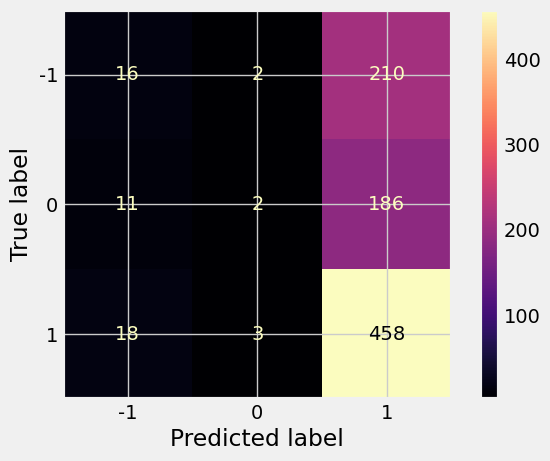

In [7]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, naive_bayes_predictions), display_labels=naive_bayes.classes_).plot(cmap='magma')

In [8]:
precision_score(ytest, naive_bayes.predict(Xtest), average='micro')

0.48627450980392156

### Então é esse o ponto que queremos superar, um score maior que 0.6 já supera nosso baseline.

In [9]:
naive_bayes_probas = naive_bayes.predict_proba(Xtrain)
# fpr, tpr, thresholds = roc_curve(ytrain, naive_bayes_probas)

In [10]:
df_naive_bayes_probas = pd.DataFrame(naive_bayes_probas, columns=["Derrota", "Empate", "Vitoria"])
train_jogos.merge(df_naive_bayes_probas, left_index=True, right_index=True).merge(ytrain, left_index=True, right_index=True)

,Casa,Visitante,Rodada,Derrota,Empate,Vitoria,Resultado
0,Oriente Petrolero,Nacional,Fase de Grupos,0.300396,0.290381,0.409223,1
1,Morelia,Santa Fe,Fase de Grupos,0.255308,0.280273,0.464419,1
2,Sporting Cristal,Atl Paranaense,Fase de Grupos,0.174299,0.215875,0.609826,1
3,SD Quito,Botafogo (RJ),Fase de Grupos,0.203907,0.263984,0.532109,1
4,Univ Chile,Guaraní,Fase de Grupos,0.212662,0.238742,0.548597,1
...,...,...,...,...,...,...,...
901,Santos,Grêmio,Quartas de final,0.466260,0.165685,0.368055,1
902,Palmeiras,Libertad,Quartas de final,0.351060,0.183483,0.465457,1
903,Racing Club,Boca Juniors,Quartas de final,0.435060,0.164227,0.400713,1
904,Nacional,River Plate,Quartas de final,0.214478,0.262295,0.523227,-1


-------
## Logistic Regression

In [11]:
from sklearn.linear_model import LogisticRegression

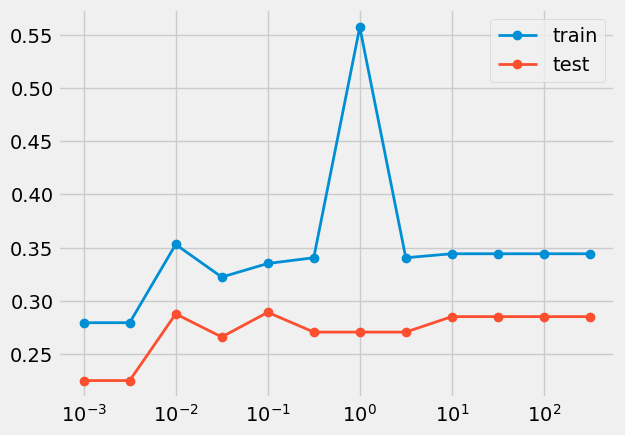

In [12]:
C = [10**i for i in np.arange(-3, 3, 0.5)]

precisions = []
precisions_test = []
for c in C:
    classif = LogisticRegression(penalty='l2', C=c).fit(Xtrain, ytrain) 
    precisions.append(precision_score(ytrain, classif.predict(Xtrain), average='weighted'))
    precisions_test.append(precision_score(ytest, classif.predict(Xtest), average='weighted'))
    
plt.figure()
plt.plot(C, precisions, marker="o", label='train')
plt.plot(C, precisions_test, marker="o", label='test')
plt.xscale("log")
plt.legend()

In [14]:
classif = LogisticRegression(penalty='l2', C=0.1).fit(Xtrain[["Senioridade Casa", "Senioridade Visitante"]], ytrain)

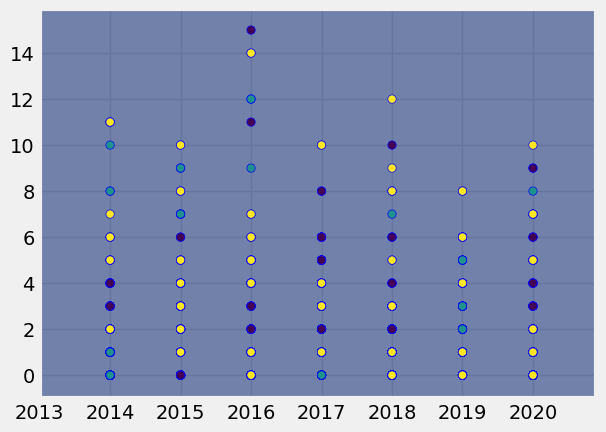

In [15]:
Xtrain_np = np.asarray(Xtrain)

# Cria uma grade de valores
x_min, x_max = Xtrain_np[:, 0].min() - 1, Xtrain_np[:, 0].max() + 1
y_min, y_max = Xtrain_np[:, 1].min() - 1, Xtrain_np[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as probabilidades para cada ponto na grade
Z = classif.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain_np[:, 0], Xtrain_np[:, 1], c=ytrain.values, edgecolors='b')
plt.show()

In [16]:
classif = LogisticRegression(penalty='l2', C=0.1).fit(Xtrain, ytrain)

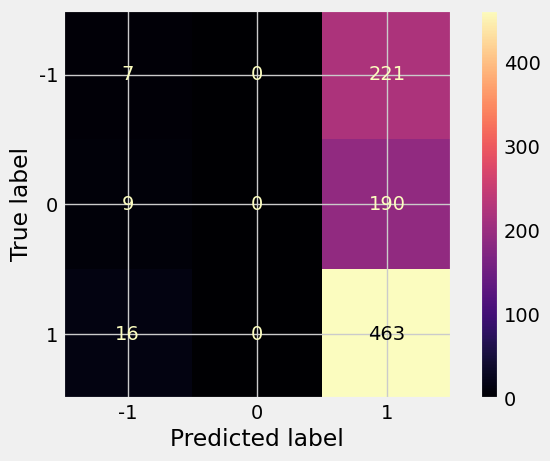

In [17]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, classif.predict(Xtrain)), display_labels=classif.classes_).plot(cmap='magma')

In [18]:
precision_score(ytest, classif.predict(Xtest), average='weighted')

0.2892681352376341

### Subimos um pouquinho, vamos testar árvores agora.

-------
## Decision Tree

In [19]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

classif = DecisionTreeClassifier(max_depth=3, criterion='entropy')
classif.fit(Xtrain, ytrain)

DecisionTreeClassifier(criterion='entropy', max_depth=3)

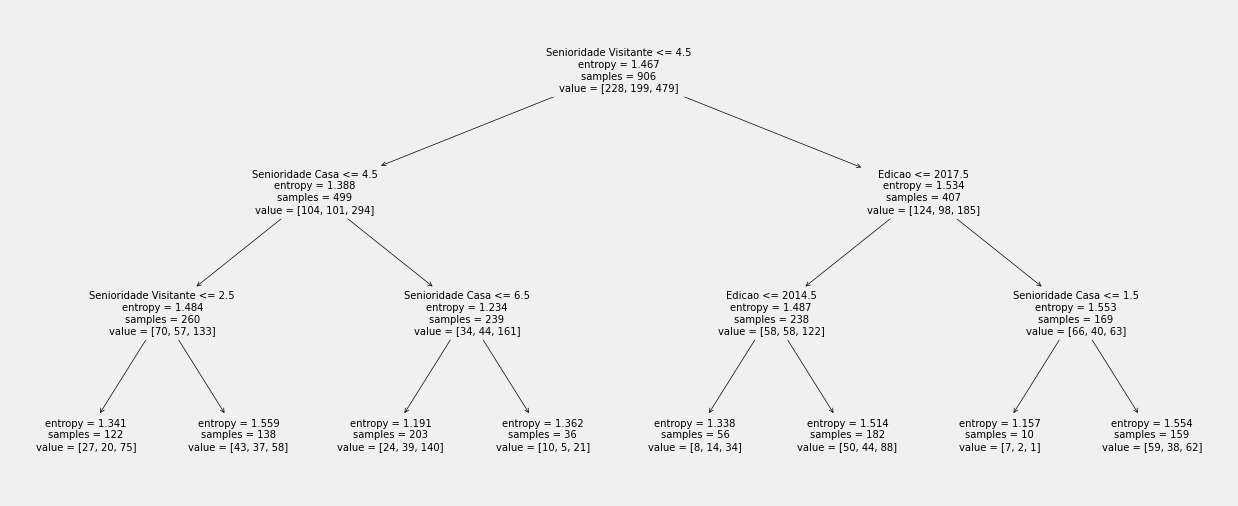

In [20]:
plt.figure(figsize=(14, 6))
plot_tree(classif, feature_names=list(classif.feature_names_in_));

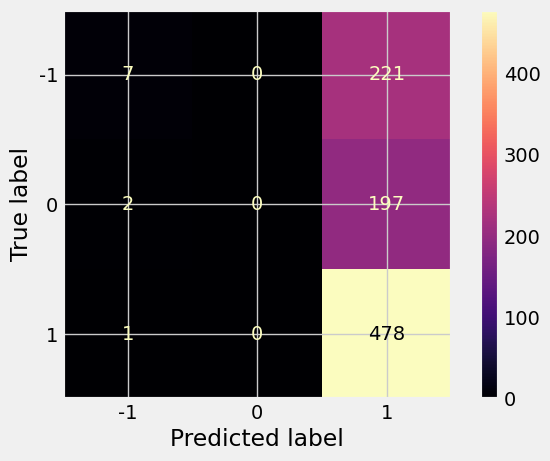

In [21]:
ConfusionMatrixDisplay(confusion_matrix(ytrain, classif.predict(Xtrain)), display_labels=classif.classes_).plot(cmap='magma')

In [22]:
precision_score(ytest, classif.predict(Xtest), average='weighted')

0.35490196078431374

-------
## Cross-Validation

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

-------
### Random Forest

In [24]:
# vamos tunar a Random Forest
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold, GridSearchCV

scv = RepeatedStratifiedKFold(n_splits=7, n_repeats=2, random_state=911)

rf_params = {
    'max_depth': [2, 3, 4],
    'max_features': ['sqrt', 'log2'],
    'n_estimators': [50, 150, 300, 500, 1000], 
    'ccp_alpha': [0.01, 0.005, 0.001],
    'min_samples_split': [2, 3, 5, 10]
}

rf_tuning = GridSearchCV(
    estimator=RandomForestClassifier(random_state=911, n_jobs=-1, class_weight='balanced_subsample', criterion='gini'),
    param_grid=rf_params, cv=scv, n_jobs=-1, scoring='precision_weighted',
    return_train_score=True
)

rf_tuning.fit(X=Xtrain, y=ytrain)

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=RandomForestClassifier(class_weight='balanced_subsample',
                                              n_jobs=-1, random_state=911),
             n_jobs=-1,
             param_grid={'ccp_alpha': [0.01, 0.005, 0.001],
                         'max_depth': [2, 3, 4],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [50, 150, 300, 500, 1000]},
             return_train_score=True, scoring='precision_weighted')

In [25]:
rf_tuning.best_params_

{'ccp_alpha': 0.005,
 'max_depth': 3,
 'max_features': 'sqrt',
 'min_samples_split': 5,
 'n_estimators': 1000}

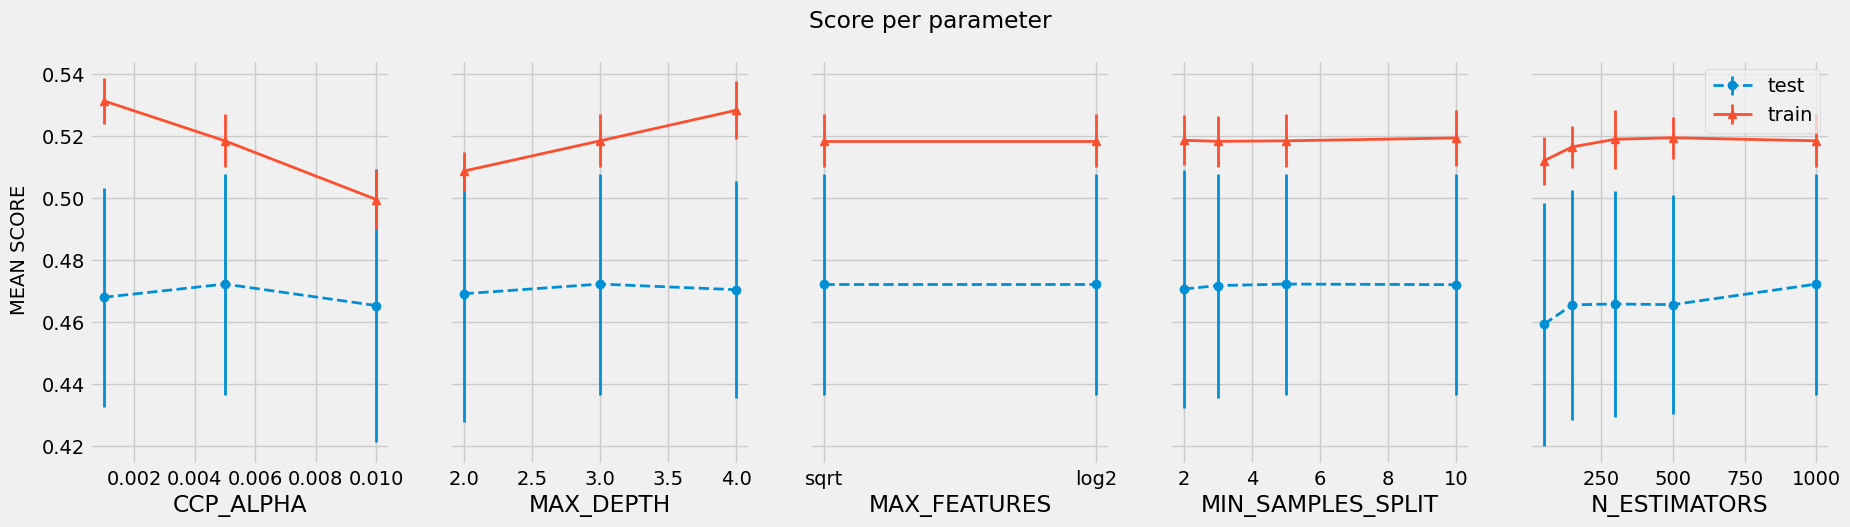

In [26]:
# code from: https://stackoverflow.com/questions/37161563/how-to-graph-grid-scores-from-gridsearchcv
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']
    means_train = results['mean_train_score']
    stds_train = results['std_train_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        y_2 = np.array(means_train[best_index])
        e_2 = np.array(stds_train[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].errorbar(x, y_2, e_2, linestyle='-', marker='^',label='train' )
        ax[i].set_xlabel(p.upper())
    plt.legend()
    plt.show()
plot_search_results(rf_tuning)

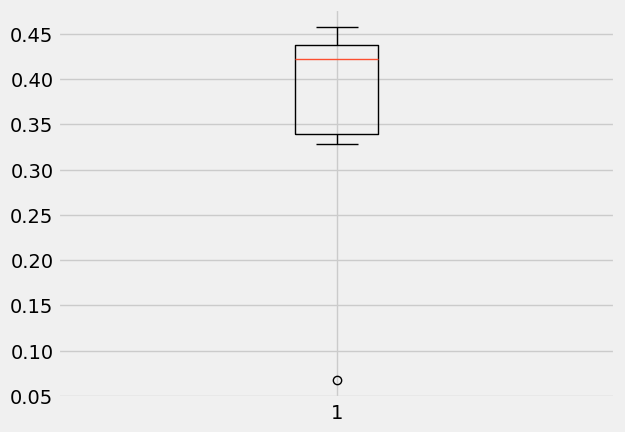

In [27]:
rf_cv = cross_val_score(rf_tuning.best_estimator_, Xtrain, ytrain, cv=7, scoring='precision_weighted')
plt.boxplot(rf_cv);

In [28]:
df_rf_probas = pd.DataFrame(rf_tuning.predict_proba(Xtest), columns=["Derrota", "Empate", "Vitoria"])
test_jogos.merge(df_rf_probas, left_index=True, right_index=True).merge(ytest, left_index=True, right_index=True)

,Casa,Visitante,Rodada,Derrota,Empate,Vitoria,Resultado
0,Boca Juniors,Santos,Semifinais,0.311489,0.299302,0.389209,0
1,River Plate,Palmeiras,Semifinais,0.363600,0.309909,0.326491,-1
2,Santos,Boca Juniors,Semifinais,0.426454,0.289778,0.283768,1
3,Palmeiras,River Plate,Semifinais,0.372592,0.307122,0.320286,-1
4,Palmeiras,Santos,Final,0.311489,0.299302,0.389209,1
...,...,...,...,...,...,...,...
250,Atl Paranaense,Palmeiras,Semifinais,0.409205,0.313220,0.277576,1
251,Vélez Sarsf,Flamengo,Semifinais,0.416980,0.326389,0.256631,-1
252,Palmeiras,Atl Paranaense,Semifinais,0.328056,0.295439,0.376505,0
253,Flamengo,Vélez Sarsf,Semifinais,0.284415,0.290467,0.425119,1


In [29]:
precision_score(ytest, rf_tuning.best_estimator_.predict(Xtest), average='weighted')

0.35131602190425715

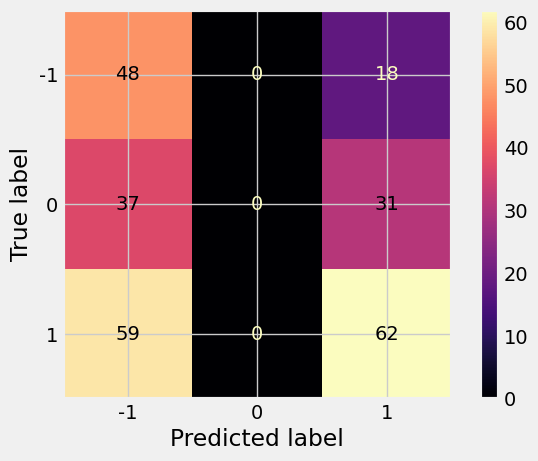

In [30]:
rf_tuned = rf_tuning.best_estimator_
rf_tuned.fit(Xtrain, ytrain)
ConfusionMatrixDisplay(confusion_matrix(ytest, rf_tuned.predict(Xtest)), display_labels=rf_tuned.classes_).plot(cmap='magma')

In [31]:
rf_tuned.feature_importances_

array([0.21272971, 0.07997301, 0.03295109, 0.31961153, 0.35473466])

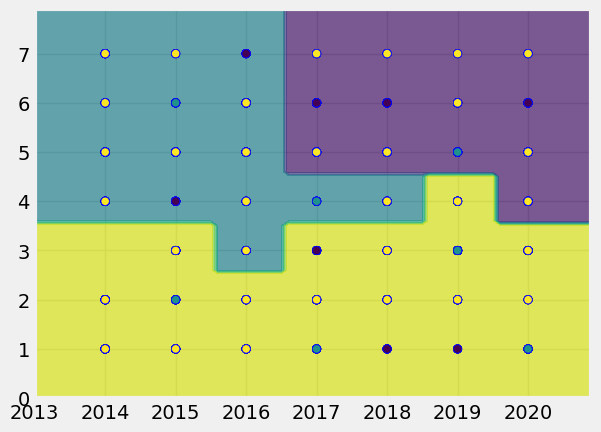

In [32]:
rf_tuned.fit(Xtrain.iloc[:, [0, 4]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 4].min() - 1, Xtrain.iloc[:, 4].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = rf_tuned.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 4], c=ytrain.values, edgecolors='b')

plt.show()

In [33]:
rf = rf_tuning.best_estimator_.fit(Xtrain, ytrain)

-------
### XGBoost

In [34]:
from xgboost import XGBClassifier

In [35]:
mapping_xgb_labels = {-1:0, 0:1, 1:2}
ytrain_map = ytrain["Resultado"].map(mapping_xgb_labels)

In [36]:
xgb_params = {
    'max_depth': [2, 3, 4],
    'n_estimators': [50, 150, 300, 500], 
    'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05],
    'subsample': [0.4, 0.5, 0.6, 0.7],
    'colsample_bytree': [0.2, 0.3, 0.4, 0.5]
}

xgb_tuning = GridSearchCV(
    estimator=XGBClassifier(random_state=911, n_jobs=-1),
    param_grid=xgb_params, cv=scv, n_jobs=-1, scoring='precision_weighted',
    return_train_score=True
)

xgb_tuning.fit(X=Xtrain, y=ytrain_map) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     import...
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=-1,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=911, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.2, 0.3, 0.4, 0.5],
                         'learning_rate': [0.0005, 0.001, 0.005, 0.01, 0.05],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [50, 150, 300, 500],
                         'subsample': [0.4, 0.5, 0.6, 0.7]},
             return_train_score=True, scoring='precision_weighted')

In [37]:
xgb_tuning.best_params_

{'colsample_bytree': 0.2,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimators': 500,
 'subsample': 0.6}

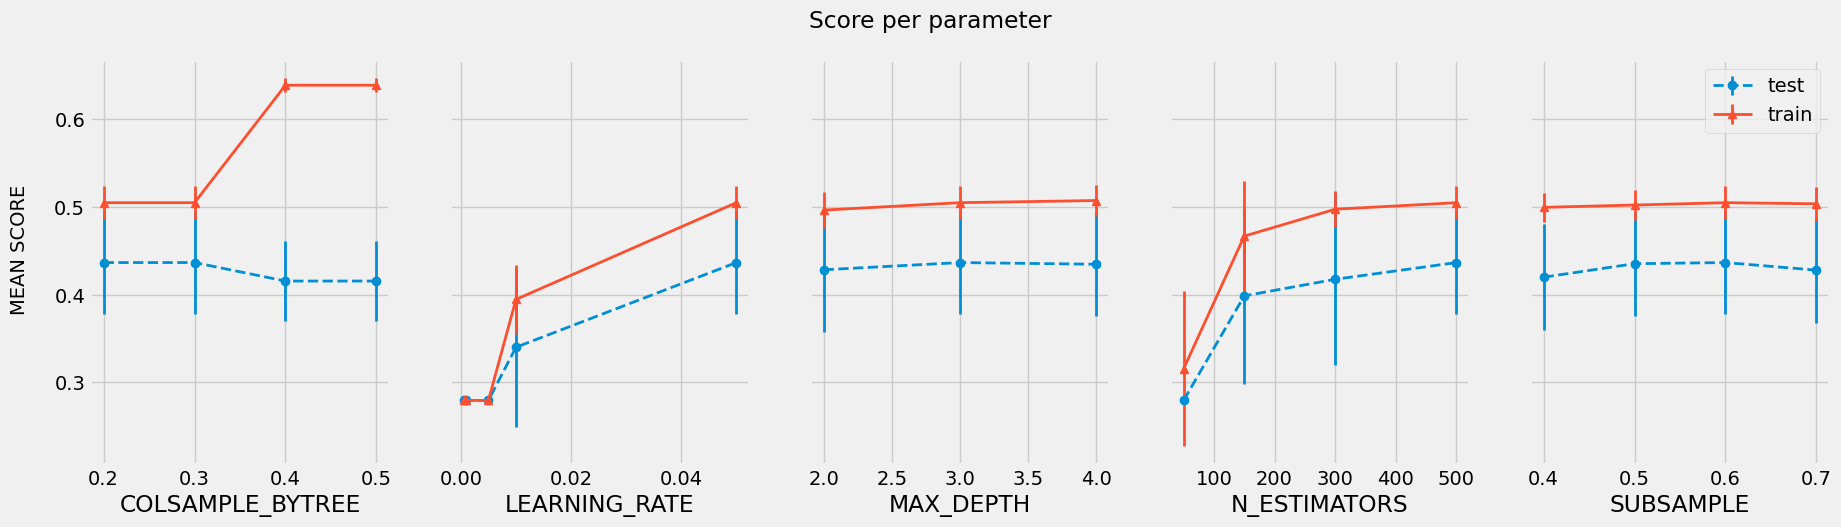

In [38]:
plot_search_results(xgb_tuning)

In [39]:
precision_score(ytest["Resultado"].map(mapping_xgb_labels), xgb_tuning.best_estimator_.predict(Xtest), average='weighted')

0.35897078054087317

In [40]:
xgb = xgb_tuning.best_estimator_.fit(Xtrain, ytrain_map)

------
### SVM

In [42]:
from sklearn.svm import SVC

#### linear

In [43]:
# hiperplanos lineares
svc_params_linear = {
    'C': [0.01, 0.1, 1, 10],
    'tol': [10e-3, 10e-2, 10e-1]}
    
            
svc_tuning_linear = GridSearchCV(
    estimator=SVC(kernel='linear', random_state=911, decision_function_shape='ovr'),
    param_grid=svc_params_linear, cv=scv, n_jobs=-1, scoring='precision_weighted',
    return_train_score=True
)

svc_tuning_linear.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=SVC(kernel='linear', random_state=911), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'tol': [0.01, 0.1, 1.0]},
             return_train_score=True, scoring='precision_weighted')

In [44]:
svc_tuning_linear.best_params_

{'C': 0.01, 'tol': 0.01}

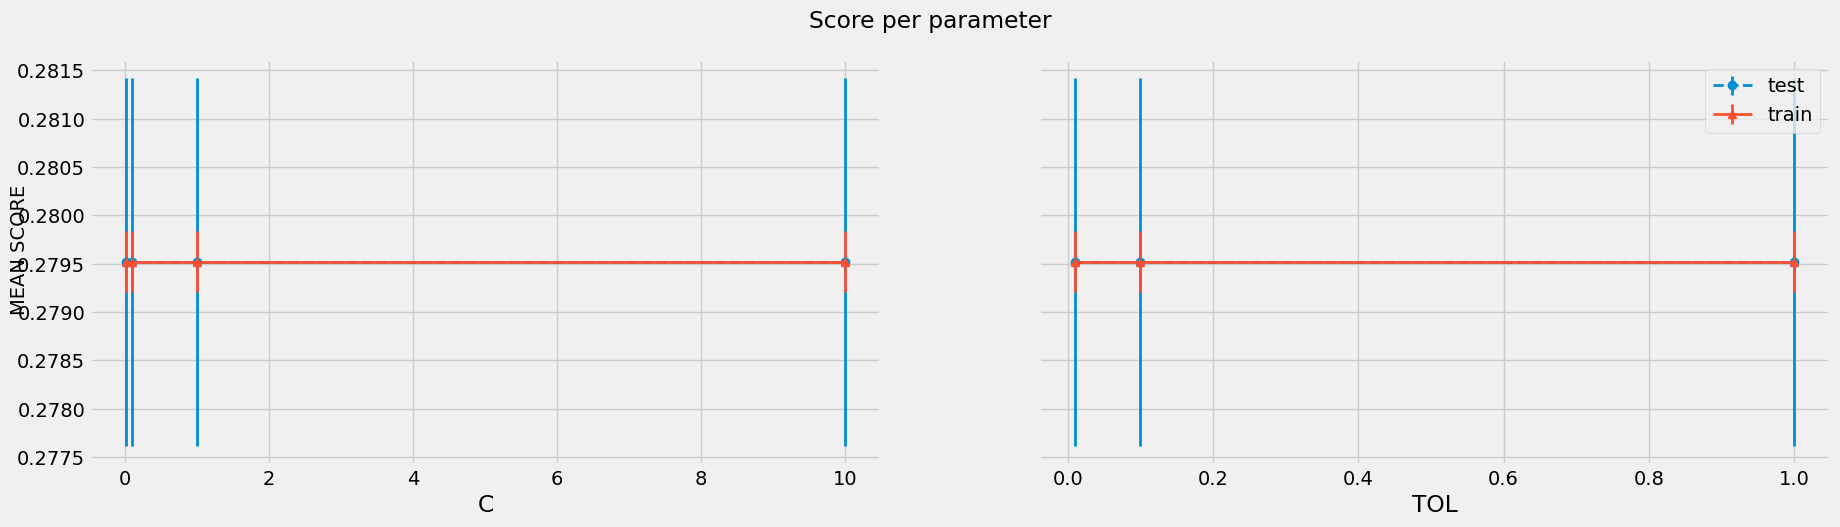

In [45]:
plot_search_results(svc_tuning_linear)

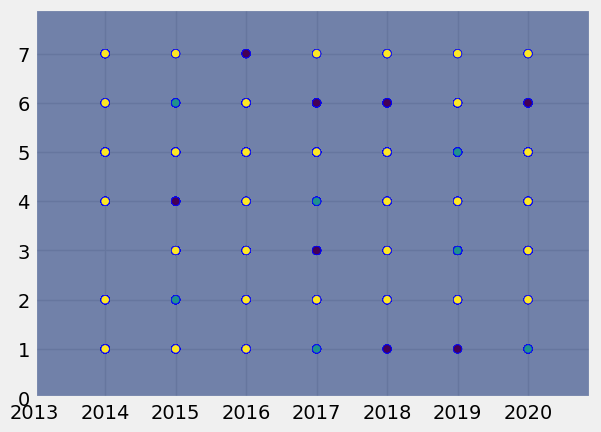

In [46]:
svc_tuning_linear.best_estimator_.fit(Xtrain.iloc[:, [0, 4]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 4].min() - 1, Xtrain.iloc[:, 4].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = svc_tuning_linear.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 4], c=ytrain.values, edgecolors='b')

plt.show()

In [47]:
svc_linear = svc_tuning_linear.best_estimator_
svc_linear.fit(Xtrain, ytrain)
precision_score(ytest, svc_linear.predict(Xtest), average='weighted')

0.2251595540176855

#### rbf

In [48]:
# hiperplanos lineares
svc_params_rbf = {
    'C': np.linspace(start=0.05, stop=0.10, num=10),
    'tol': np.linspace(start=0.01, stop=0.10, num=5),
    'gamma': np.linspace(start=1, stop=10, num=10)
}
    
            
svc_tuning_rbf = GridSearchCV(
    estimator=SVC(kernel='rbf', random_state=911, decision_function_shape='ovr'),
    param_grid=svc_params_rbf, cv=scv, n_jobs=-1, scoring='precision_weighted',
    return_train_score=True
)

svc_tuning_rbf.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=SVC(random_state=911), n_jobs=-1,
             param_grid={'C': array([0.05      , 0.05555556, 0.06111111, 0.06666667, 0.07222222,
       0.07777778, 0.08333333, 0.08888889, 0.09444444, 0.1       ]),
                         'gamma': array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.]),
                         'tol': array([0.01  , 0.0325, 0.055 , 0.0775, 0.1   ])},
             return_train_score=True, scoring='precision_weighted')

In [49]:
svc_tuning_rbf.best_params_

{'C': 0.05, 'gamma': 1.0, 'tol': 0.01}

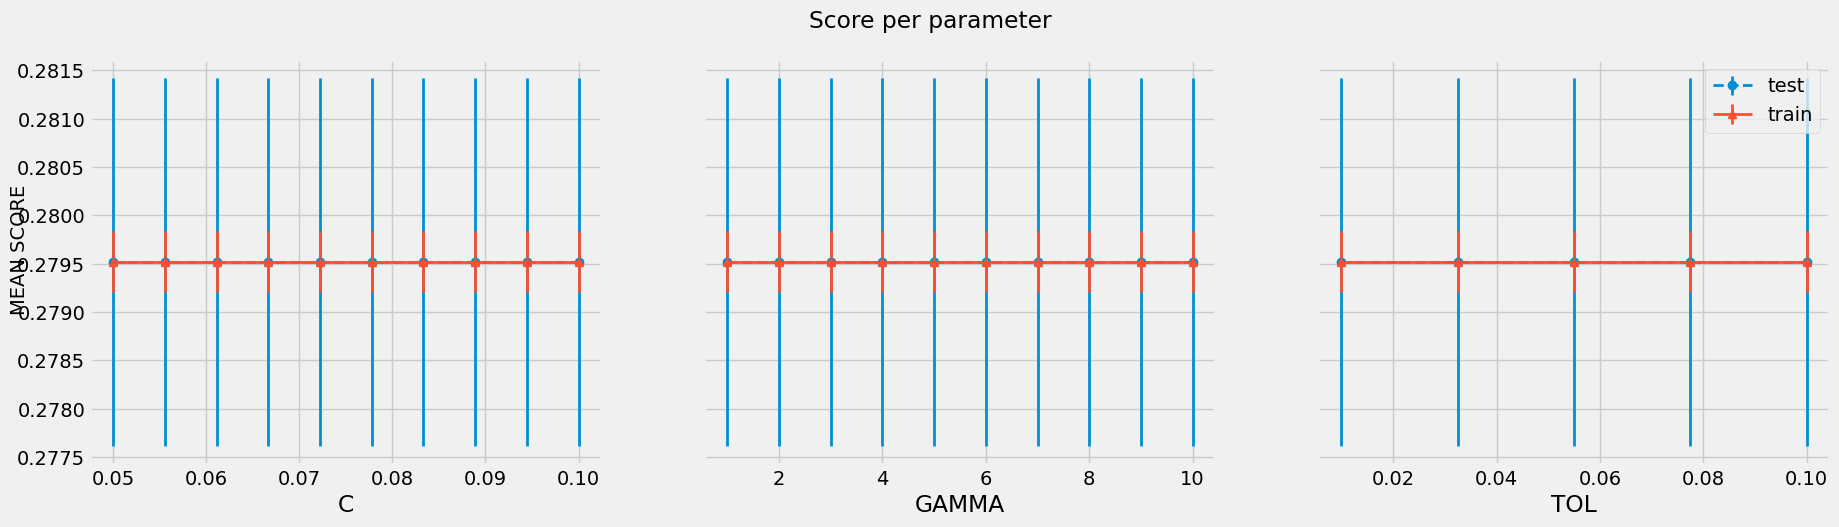

In [50]:
plot_search_results(svc_tuning_rbf)

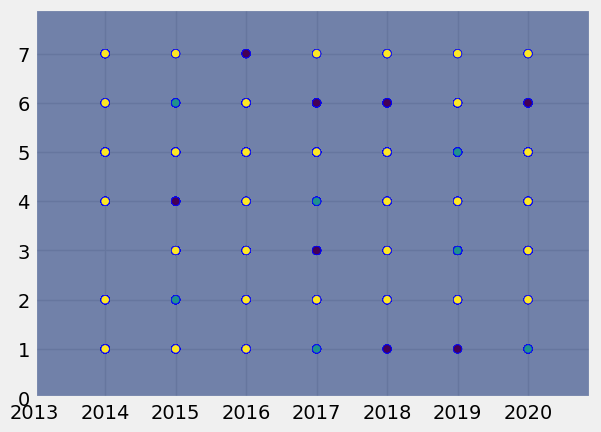

In [51]:
svc_tuning_rbf.best_estimator_.fit(Xtrain.iloc[:, [0, 4]], ytrain)

# Cria uma grade de valores
x_min, x_max = Xtrain.iloc[:, 0].min() - 1, Xtrain.iloc[:, 0].max() + 1
y_min, y_max = Xtrain.iloc[:, 4].min() - 1, Xtrain.iloc[:, 4].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Calcula as classes para cada ponto na grade
Z = svc_tuning_rbf.best_estimator_.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plota as regiões de decisão
plt.contourf(xx, yy, Z, alpha=0.7)

# Plota os pontos do conjunto de dados
plt.scatter(Xtrain.iloc[:, 0], Xtrain.iloc[:, 4], c=ytrain.values, edgecolors='b')

plt.show()

In [52]:
svc_rbf = svc_tuning_rbf.best_estimator_
svc_rbf.fit(Xtrain, ytrain)
precision_score(ytest, svc_rbf.predict(Xtest), average='weighted')

0.2251595540176855

-------
### Logistic Regression

In [53]:
lr_params = {
    'C': [10**i for i in np.arange(-3, 3, 0.5)],
    'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
    'tol': [10e-3, 10e-2, 10e-1]
}       
              

lr_tuning = GridSearchCV(
    estimator=LogisticRegression(multi_class='ovr', penalty='l2'),
    param_grid=lr_params, cv=scv, n_jobs=-1, scoring='precision_weighted',
    return_train_score=True
)

lr_tuning.fit(X=Xtrain, y=ytrain) 

GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=2, n_splits=7, random_state=911),
             estimator=LogisticRegression(multi_class='ovr'), n_jobs=-1,
             param_grid={'C': [0.001, 0.0031622776601683794, 0.01,
                               0.03162277660168379, 0.1, 0.31622776601683794,
                               1.0, 3.1622776601683795, 10.0,
                               31.622776601683793, 100.0, 316.22776601683796],
                         'solver': ['lbfgs', 'liblinear', 'newton-cg', 'saga'],
                         'tol': [0.01, 0.1, 1.0]},
             return_train_score=True, scoring='precision_weighted')

In [54]:
lr_tuning.best_params_

{'C': 0.31622776601683794, 'solver': 'newton-cg', 'tol': 0.01}

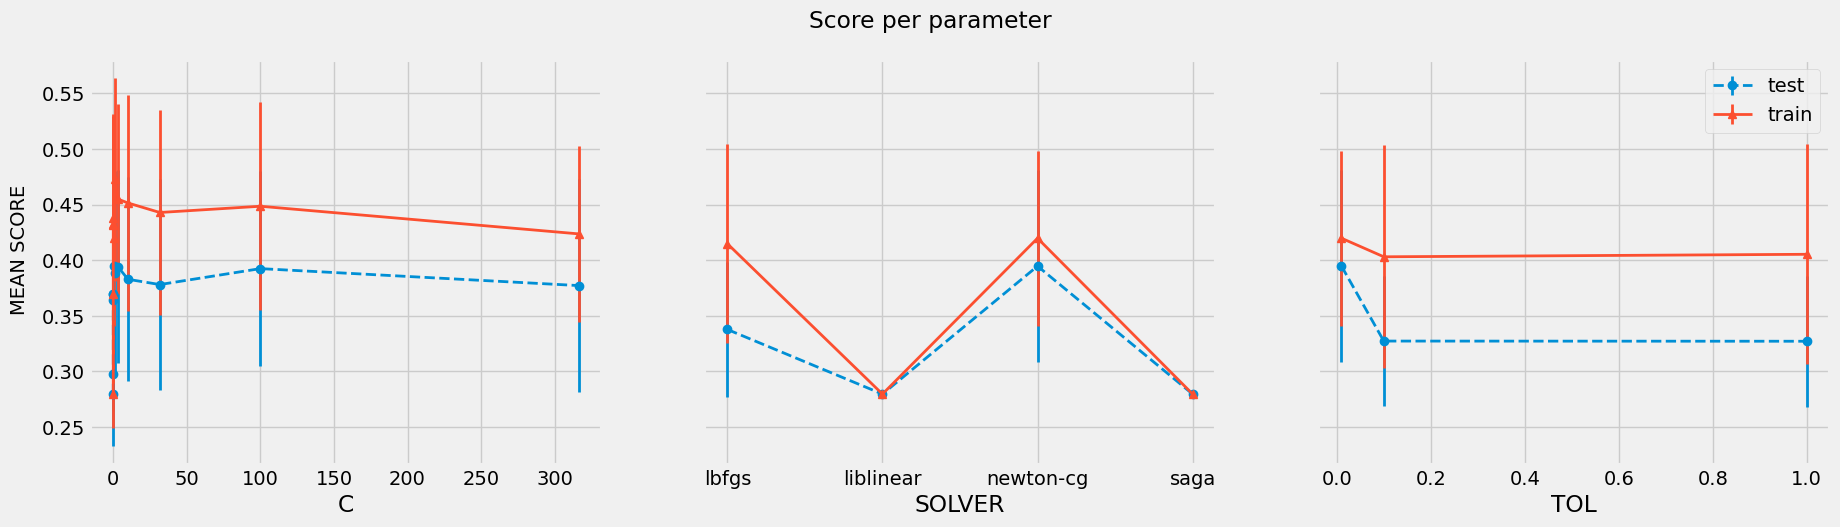

In [55]:
plot_search_results(lr_tuning)

In [56]:
precision_score(ytest, lr_tuning.best_estimator_.predict(Xtest), average='weighted')

0.35310207967390284

### Voting

In [59]:
from sklearn.ensemble import VotingClassifier
ytest_map = ytest["Resultado"].map(mapping_xgb_labels)

rf = rf_tuning.best_estimator_.fit(Xtrain, ytrain_map)
lr = lr_tuning.best_estimator_.fit(Xtrain, ytrain_map)

voting = VotingClassifier(estimators=[
    ("lr", lr),
    ("rf", rf),
    ('xgb', xgb)
],  voting='soft', n_jobs=-1)

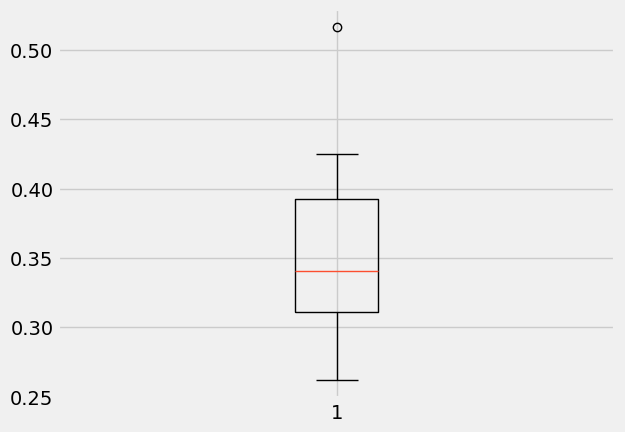

In [60]:
voting_cv = cross_val_score(voting, Xtrain, ytrain_map, cv=7, scoring='precision_weighted')
plt.boxplot(voting_cv);

In [61]:
voting.fit(Xtrain, ytrain_map)
precision_score(ytest_map, voting.predict(Xtest), average='weighted')

0.3497615262321145

-----
## Escolhendo o melhor modelo

In [62]:
def batalha_de_modelos(modelos, X, y, scoring):
    resultados = pd.DataFrame()
    for modelo in modelos:
        nome, m = modelo[0], modelo[1]
        result_cv = cross_val_score(m, X, y, cv=7, scoring=scoring)
        resultados[nome] = result_cv

    plt.figure(figsize=(14, 5))
    plt.boxplot(resultados, labels=resultados.columns)
    
    return resultados

In [63]:
modelos_batalha = [('LR', lr_tuning.best_estimator_), ('RF', rf_tuning.best_estimator_), ('XGB', xgb_tuning.best_estimator_), 
             ('SVR linear', svc_tuning_linear.best_estimator_), ('SVR rbf', svc_tuning_rbf.best_estimator_), ('Voting', voting)]

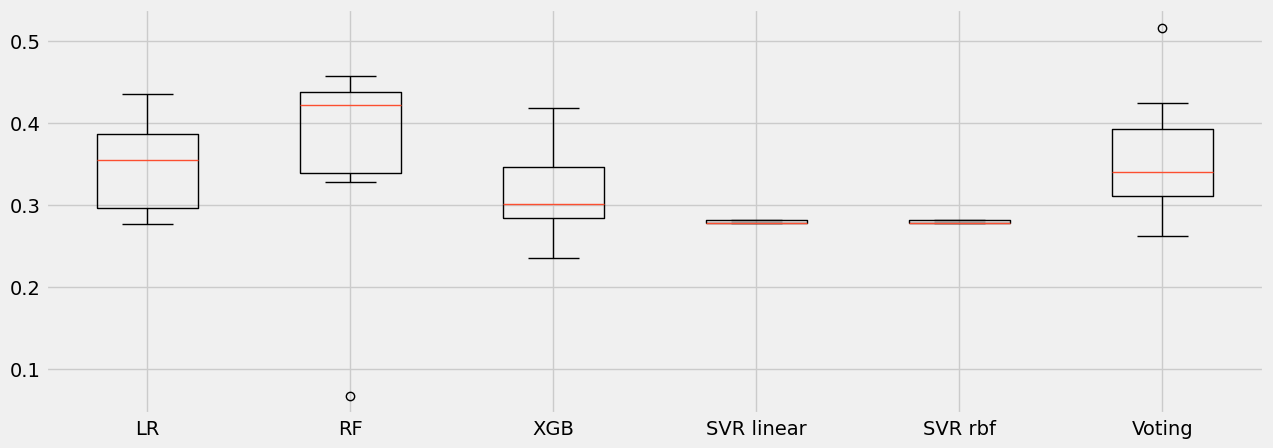

In [64]:
resultados_cv = batalha_de_modelos(
    modelos=modelos_batalha, X=Xtrain, y=ytrain_map, scoring='precision_weighted'
)

--------
--------
# Err - as coisas não estão indo bem, vamos mudar o objetivo do projeto para um classificador binário: 1-vitória, 0-caso contrário.

In [ ]:
xgb